## Covid Morbidity Factors Exploration Project
### Chris Weilacker, Kirk Kosinski, Patrick Cao, OJ Alcaraz
### 9 February 2021

#### Datasets are orginally from the following:

##### COVID-19 Case Mortality Ratios by Country

https://www.kaggle.com/paultimothymooney/coronavirus-covid19-mortality-rate-by-country
Covid-19 Mortality Rate by Country

##### Percentage of Population 65 and Over by Country (2019)
https://www.kaggle.com/krukmat/demographic-and-socioeconomic-unesco
65 % of Population Feature

##### Percentage of Obesity among Adults by Country (2016)
https://www.kaggle.com/amanarora/obesity-among-adults-by-country-19752016
Obesity Percentage Feature

##### Life Expectancy at Birth(HALE) by Country (2019)
https://www.kaggle.com/utkarshxy/who-worldhealth-statistics-2020-complete
Life Expectancy Feature


### Problem Question: Can we create a model that can predict the risk for the Case Mortality Ratio of a Country utilizing its Life Expectancy, Percentage of Population over 65, and Percentage of Obesity?

#### We decided on using Population Over Age 65 and Obesity because in the US, over 80% of the deaths were in the population 65 and over, and the CDC has stated that 94% of deaths had some underlying health condition.  We also used Life Expectency per country to account for possible deficiencies in the health care system. John Hopkins University has listed several diseases such as heart disease and Diabetes which are known to be exacerbated by Obesity. Our idea is that we can more accurately predict the Mortality Ratio of COVID-19 by using both population 65 and over and Obesity rather than just population 65 and over. This may show that creating a healthier population is the best way to prevent the devastation in future pandemics that the US is currently facing.

### On the following slide we will run some Data Preprocessing to get all of our data in one Data Frame df.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# allow output to span multiple output lines in the console
pd.set_option('display.max_columns', 500)

# switch to seaborn default stylistic parameters
# see the very useful https://seaborn.pydata.org/tutorial/aesthetics.html
sns.set()
sns.set_context('talk')

# change default plot size
rcParams['figure.figsize'] = 10,8
# Covid Data
covidDF = pd.read_csv('https://raw.githubusercontent.com/chrisweilacker/CovidMachineLearningProject/master/global_covid19_mortality_rates.csv', index_col=0)
# 2016 Obesity Data for Both Sexes is in Column Both Sexes
obesityDF = pd.read_csv('https://raw.githubusercontent.com/chrisweilacker/CovidMachineLearningProject/master/obesity-data.csv', skiprows=3)
# Demographics Data which includes the percentage of population over 65 per country.
demoDF = pd.read_csv('https://raw.githubusercontent.com/chrisweilacker/CovidMachineLearningProject/master/DEMO_Global.csv')
# Life Expectancy at Birth Data
lifeDF = pd.read_csv('https://raw.githubusercontent.com/chrisweilacker/CovidMachineLearningProject/master/HALElifeExpectancyAtBirth.csv')

lifeDF.rename(columns={'Location': 'Country', 'First Tooltip': 'Life_Expectancy'}, inplace=True)

# Create our DataFrame with the necessary data from all three datasets
df = covidDF.merge(obesityDF[['Country', 'Both sexes']], how='inner') #Copy in the whole Covid Data and the Obesity Data
# Modify name of Both Sexes to Obesity and get just the number
df.rename(columns={'Both sexes': 'Obesity'}, inplace=True)
obNumber = df['Obesity'].str.split(" ", n = 1, expand = True) 
df['Obesity'] = obNumber[0]

#Drop Rows with no Obesity Data
df.drop(df.loc[df['Obesity']=='No'].index, inplace=True)
#Drop Rows with no Covid Data
df.drop(df.loc[df['Mortality Ratio']==0].index, inplace=True)
df.rename(columns={'Mortality Ratio': 'Covid-19 Mortality Ratio'}, inplace=True)
# Convert Obesity data to float
df['Obesity'] = pd.to_numeric(df['Obesity'], downcast="float")

df.drop(df.loc[df['Country']=='Yemen'].index,inplace=True)

# Get the Pop 65 and Over and Tot Pop Data to Calculate Percent 65 and Over
df = df.merge(demoDF[['Country', 'Value']][(demoDF['Time']==2017) & (demoDF['Indicator']=='Population aged 65 years or older ')], how='inner') #Copy in the 65 and Over Data
df.rename(columns={'Value': 'Pop65Over'}, inplace=True)
df = df.merge(demoDF[['Country', 'Value']][(demoDF['Time']==2017) & (demoDF['Indicator']=='Total population ')], how='inner') #Copy in the 65 and Over Data
df.rename(columns={'Value': 'TotPop'}, inplace=True)

# Add In Life Expectancy Data
df = df.merge(lifeDF[['Country', 'Life_Expectancy']][(lifeDF['Period']==2019) & (lifeDF['Dim1']=='Both sexes')])

# Create Perc 65 and Over
df['Perc65Over'] = (100 * df['Pop65Over']/df['TotPop'])

corr = df[['Covid-19 Mortality Ratio', 'Perc65Over', 'Obesity', 'Life_Expectancy']].corr()
#It seems that there is a correlation between both Perc 65 and Over, Obesity and Covid-19 Mortality Ratio
#Though the Perc65 and Over seems to be stronger than Obesity, but the data hasnt been normalized yet.
#We may later want to bring in another dimension such as functionality of the countries health system
# depending on what the ML algorithm can do.


# We might need to create a categorical column for mortality whether it is high risk or not
# and see if an ML algorithm such as KNN can use the obesity and Over 65 Population to 
# categorize the data would be more accurate. We used the normalization of the Mortality-Ratio with
# all mortality ratio's above 0.65 standard deviations as being considered High Risk, which equals about
# 25% of the worst cases.

df['HighRisk'] = zscore(df['Covid-19 Mortality Ratio']) > 0.65
df['NormCovid19Mortality'] = zscore(df['Covid-19 Mortality Ratio'])

corr.style.background_gradient(cmap='coolwarm')

,Covid-19 Mortality Ratio,Perc65Over,Obesity,Life_Expectancy
Covid-19 Mortality Ratio,1.000000,0.282377,0.073821,0.131760
Perc65Over,0.282377,1.000000,0.382824,0.727345
Obesity,0.073821,0.382824,1.000000,0.570750
Life_Expectancy,0.131760,0.727345,0.570750,1.000000


### Data Visualizations

_The following are Data Visualizations for Life Expectancy, Perc65Over and Obesity with regards to Covid-19 Mortality Ratio's which is simply the percentage of deaths vs population._

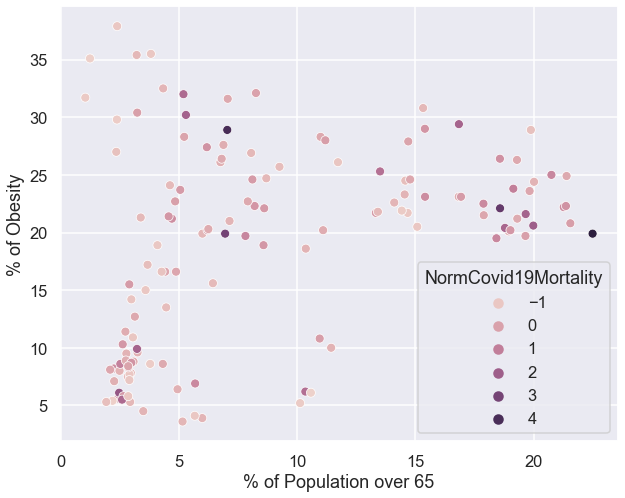

In [2]:
sns.scatterplot(data=df, x='Perc65Over', y='Obesity', hue='NormCovid19Mortality');
plt.xlabel("% of Population over 65")
plt.ylabel("% of Obesity");

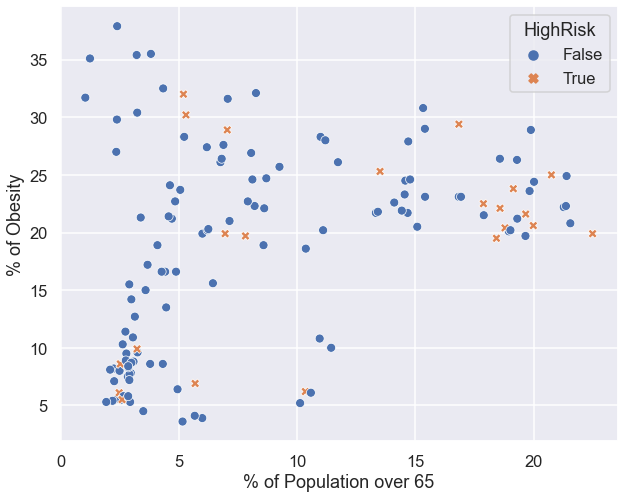

In [3]:
sns.scatterplot(data=df, x='Perc65Over', y='Obesity', hue='HighRisk', style='HighRisk');
plt.xlabel("% of Population over 65")
plt.ylabel("% of Obesity");

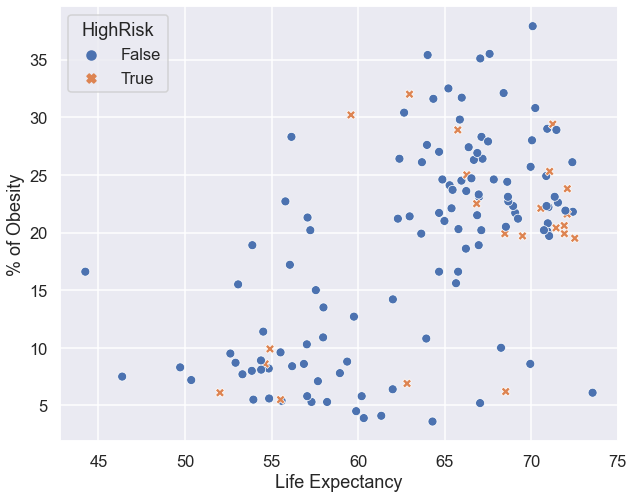

In [4]:
sns.scatterplot(data=df, x='Life_Expectancy', y='Obesity', hue='HighRisk', style='HighRisk')
plt.xlabel("Life Expectancy")
plt.ylabel("% of Obesity");

_After viewing the graphs we are concerned about the accuracy that ML algorithms can achieve with this data. The data may improve as more accurate case data is produced from Antibody testing.  We will continue and see if our ML Algorithm can do better than we are expecting. We have initially chosen to use categorization with the HighRisk category as that may be more accurate than regression._

### Now we will split our data for the Machine Learning Algorithm using the High Risk Category as our target and Life_Expectancy,  Obesity, and Perc65andOver as features

In [5]:
# select the predictor variables and target variables to be used with categorization
predictors = ['Life_Expectancy', 'Obesity', 'Perc65Over']
target = 'HighRisk'
X = df[predictors].values
y = df[target].values

# Split the data into training and test sets, and scale
scaler = StandardScaler()

# unscaled version (note that scaling is only used on predictor variables)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# scaled version
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)
print('First 10 Rows of Scaled Data: \n\n', X_train[0:10:,], '\n')

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)
accuracy = (predictions == y_test).mean()
print('Accuracy:', round(accuracy * 100, 2), '%')

First 10 Rows of Scaled Data: 

 [[ 1.34495589  0.42364862  0.91502593]
 [-0.0946856   0.93124336 -0.2702394 ]
 [ 1.26389162  0.25445037  1.59418223]
 [-0.51501889  1.35987904 -0.50554106]
 [ 1.13178687  0.44620847  1.56182279]
 [ 0.13799889 -0.82841834  0.37472146]
 [-0.00761657  1.56291685 -0.52174267]
 [-1.1169962  -1.43753204 -0.98852888]
 [-1.56134852 -0.97505684 -0.89757346]
 [ 0.48477385  0.61540672  1.75612059]] 

Accuracy: 76.19 %


### It looks like despite our initial reservations that KNN was able to get a decent accuracy of 76.7%
#### Let's test which k value gets us our best accuracy.

In [6]:
n = 8
accuracies = []
ks = np.arange(1, n+1, 2)
for k in ks:
    print(k, ' ', end='')
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    predictions = knn.predict(X_test)
    acc = (predictions == y_test).mean()
    accuracies.append(acc)
print('done')

def get_best(ks, accuracies):
    maximum = np.array(accuracies).max()
    indexMax = np.where(accuracies == maximum)
    return ks[indexMax], maximum

best_k, best_acc = get_best(ks, accuracies)
print('best k = {}, best accuracy: {:0.3f}%'.format(best_k, best_acc * 100))



1  3  5  7  done
best k = [3], best accuracy: 78.571%


### Interestingly a slightly better classification of 78% with  k =  3.

In [7]:

print('Comparison of predictions to y_test values: \n\n', predictions == y_test)
print('\nPredictions:\n\n', predictions)
print('\nY_test values:\n\n', y_test)

Comparison of predictions to y_test values: 

 [ True False  True False False False False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True  True  True  True False False
  True  True  True False  True False]

Predictions:

 [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False  True  True
 False False False False False False]

Y_test values:

 [False  True False  True  True  True  True False False False False False
 False False False False False False False False False False  True False
 False False False False False False False False False False False False
 False False False  True False  True]


### A further look at our predictions and Y_test values show that we get 78% simply by predicting almost everything as False so this model's features and data should be improved.

### We have decided to add more features based on the following data set. 
https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-codebook.csv
#### We will be using the diabetes, cardiovascular health, percent of poplation above 70 and any other data we find to be the most useful to see if we can get better results with these extra features.

In [8]:
#Get the One World in Data Dataset
owidDF = pd.read_csv('https://raw.githubusercontent.com/chrisweilacker/CovidMachineLearningProject/master/owid-covid-latest.csv', index_col=0)
owidDF.rename(columns={'location': 'Country'}, inplace=True)
#Bring in the interesting features from the Dataset
df = df.merge(owidDF[['Country', 'total_deaths_per_million', 
                      'cardiovasc_death_rate', 'diabetes_prevalence', 'human_development_index', 'population_density', 
                      'aged_70_older', 'female_smokers', 'male_smokers', 'extreme_poverty']], how='inner')

# 'human_development_index' A composite index measuring average achievement in three basic dimensions of human development—a long and healthy life, knowledge and a decent standard of living. Values for 2019, imported from http://hdr.undp.org/en/indicators/137506
# 'aged_70_older' Share of the population that is 70 years and older in 2015
# 'population_density' Number of people divided by land area, measured in square kilometers, most recent year available
# 'total_deaths_per_million' Total deaths attributed to COVID-19 per 1,000,000 people


#We note there are some more Null values once we have these features.
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137 entries, 0 to 136
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Country                   137 non-null    object 
 1   Confirmed                 137 non-null    float64
 2   Deaths                    137 non-null    float64
 3   Covid-19 Mortality Ratio  137 non-null    float64
 4   Latitude                  137 non-null    float64
 5   Longitude                 137 non-null    float64
 6   Country_Code              136 non-null    object 
 7   Obesity                   137 non-null    float32
 8   Pop65Over                 137 non-null    float64
 9   TotPop                    137 non-null    float64
 10  Life_Expectancy           137 non-null    float64
 11  Perc65Over                137 non-null    float64
 12  HighRisk                  137 non-null    bool   
 13  NormCovid19Mortality      137 non-null    float64
 14  total_deat

In [9]:
corr = df[['Covid-19 Mortality Ratio', 'total_deaths_per_million', 'Perc65Over', 'Obesity', 'Life_Expectancy', 'cardiovasc_death_rate', 'diabetes_prevalence', 'human_development_index', 'population_density', 'aged_70_older', 'Latitude']].corr()
corr.style.background_gradient(cmap='coolwarm')
#Total deaths attributed to COVID-19 per 1,000,000 people
#With the new data the correlations seem stronger on aged_70_older, human_dev_index, Life_Expectancy, and Obesity than before.

,Covid-19 Mortality Ratio,total_deaths_per_million,Perc65Over,Obesity,Life_Expectancy,cardiovasc_death_rate,diabetes_prevalence,human_development_index,population_density,aged_70_older,Latitude
Covid-19 Mortality Ratio,1.000000,0.398426,0.282377,0.073821,0.131760,-0.188822,-0.127085,0.106381,-0.154768,0.289082,0.151596
total_deaths_per_million,0.398426,1.000000,0.660897,0.417138,0.552755,-0.288895,-0.045550,0.566253,-0.089782,0.668810,0.384547
Perc65Over,0.282377,0.660897,1.000000,0.382824,0.727345,-0.325584,-0.071746,0.772791,0.021778,0.993050,0.552985
Obesity,0.073821,0.417138,0.382824,1.000000,0.570750,-0.183351,0.429005,0.660623,-0.143055,0.380224,0.259603
Life_Expectancy,0.131760,0.552755,0.727345,0.570750,1.000000,-0.489434,0.270498,0.901917,0.176428,0.715725,0.507576
cardiovasc_death_rate,-0.188822,-0.288895,-0.325584,-0.183351,-0.489434,1.000000,0.035380,-0.408283,-0.165804,-0.338228,0.032154
diabetes_prevalence,-0.127085,-0.045550,-0.071746,0.429005,0.270498,0.035380,1.000000,0.287392,0.153033,-0.103363,-0.006809
human_development_index,0.106381,0.566253,0.772791,0.660623,0.901917,-0.408283,0.287392,1.000000,0.134535,0.762251,0.465533
population_density,-0.154768,-0.089782,0.021778,-0.143055,0.176428,-0.165804,0.153033,0.134535,1.000000,0.020857,-0.044243
aged_70_older,0.289082,0.668810,0.993050,0.380224,0.715725,-0.338228,-0.103363,0.762251,0.020857,1.000000,0.555894


### Using the new updated Data (the previous Data was from 5 months ago), we have decided to update the High Risk and base it off of total_deaths_per_million which is the Total deaths attributed to COVID-19 per 1,000,000 people according to John Hopkins University as of 2/21/2021, which should get us near the same results just with more up to date data.

In [10]:
df['HighRisk'] = zscore(df['total_deaths_per_million']) > 0.65
df['Normalized Covid19 Death / Population'] = zscore(df['Covid-19 Mortality Ratio'])
#Simply to better display on a pair plot
df['Norm. Covid19 Death / Pop'] = df['Normalized Covid19 Death / Population']
df['Human Dev. Index'] = df['human_development_index']

### Now we will try to test all the features we currently have and select through a greedy algorithm the best features utilizing KNN and all K-Ranges between 1 and 7.

In [11]:
predictors = ['Latitude', 'Longitude', 'Obesity', 'Perc65Over', 'Life_Expectancy', 'cardiovasc_death_rate', 'diabetes_prevalence', 'human_development_index', 'aged_70_older', 'population_density', 'female_smokers', 'male_smokers', 'extreme_poverty']
target = 'HighRisk'
X = df[predictors].values
y = df[target].values
# Split the data into training and test sets, and scale
scaler = StandardScaler()

# unscaled version (note that scaling is only used on predictor variables)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# scaled version
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

ks = np.arange(1, 8, 2)
for k in ks:
    best_acc = 0
    selected = []
    remaining = list(range(X_train.shape[1]))
    n = 11
    better = True
    while len(selected) < n and better == True:
        # find the single features that works best in conjunction
        # with the already selected features
        acc_max = 0
        for i in remaining:
            # make a version of the training data with just selected, feature i
            selectedFi = selected.copy()
            selectedFi.append(i)
            X_si = X_train[:,selectedFi]
            y_siTrain = y_train[~np.isnan(X_si).any(axis=1)]
            X_si=X_si[~np.isnan(X_si).any(axis=1)]
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_si, y_siTrain)
            X_testSi = X_test[:,selectedFi]
            y_siTest = y_test[~np.isnan(X_testSi).any(axis=1)]
            X_testSi = X_testSi[~np.isnan(X_testSi).any(axis=1)]
            predictions = knn.predict(X_testSi)

            acc = (predictions == y_siTest).mean()
            if (acc > acc_max):
                acc_max = acc
                i_min = i
                if (best_acc < acc):
                    best_acc = acc
                    better = True
                else:
                    better = False


        if (better == True):        
            remaining.remove(i_min)
            selected.append(i_min)
            print('k: {}; num features: {}; features: {}; bestAcc: {:.2f}%'.format(k, len(selected), [predictors[x] for x in selected], best_acc*100))
    

k: 1; num features: 1; features: ['Obesity']; bestAcc: 83.33%
k: 1; num features: 2; features: ['Obesity', 'extreme_poverty']; bestAcc: 85.71%
k: 3; num features: 1; features: ['human_development_index']; bestAcc: 78.57%
k: 3; num features: 2; features: ['human_development_index', 'male_smokers']; bestAcc: 81.82%
k: 3; num features: 3; features: ['human_development_index', 'male_smokers', 'Latitude']; bestAcc: 84.85%
k: 3; num features: 4; features: ['human_development_index', 'male_smokers', 'Latitude', 'female_smokers']; bestAcc: 87.88%
k: 3; num features: 5; features: ['human_development_index', 'male_smokers', 'Latitude', 'female_smokers', 'Obesity']; bestAcc: 90.91%
k: 5; num features: 1; features: ['Obesity']; bestAcc: 83.33%
k: 5; num features: 2; features: ['Obesity', 'female_smokers']; bestAcc: 85.29%
k: 5; num features: 3; features: ['Obesity', 'female_smokers', 'Life_Expectancy']; bestAcc: 91.18%
k: 7; num features: 1; features: ['Obesity']; bestAcc: 83.33%
k: 7; num feature

### Looking at the data above we have gotten a bit better accuracy using k=7 with the following 5 features:
#### 'human_development_index', 'Obesity', 'Pop65Over', 'female_smokers', 'Life_Expectancy', 'human_development_index'

### We used similar code but implemented cross-validation using the entire dataset instead of a test, train split approach

In [12]:
predictors = ['Latitude', 'Longitude', 'Obesity', 'Perc65Over', 'Life_Expectancy', 'cardiovasc_death_rate', 'diabetes_prevalence', 'human_development_index', 'aged_70_older', 'population_density', 'female_smokers', 'male_smokers', 'extreme_poverty']
target = 'HighRisk'
X = df[predictors].values
y = df[target].values
# Split the data into training and test sets, and scale
scaler = StandardScaler()



# scaled version of original data
X_scaled = scaler.fit_transform(X)


ks = np.arange(1, 8, 2)
for k in ks:
    best_acc = 0
    selected = []
    remaining = list(range(X_train.shape[1]))
    n = 11
    better = True
    while len(selected) < n and better == True:
        # find the single features that works best in conjunction
        # with the already selected features
        acc_max = 0
        for i in remaining:
            # Make a version of the training data with just selected, feature i
            selectedFi = selected.copy()
            selectedFi.append(i)
            X_si = X_scaled[:,selectedFi]
            # Remove any rows that any of the data is nan
            y_si = y[~np.isnan(X_si).any(axis=1)]
            X_si = X_si[~np.isnan(X_si).any(axis=1)]
            
            #Create a cross validation score to get its mean
            scores = cross_val_score(KNeighborsClassifier(n_neighbors=k), X_si, y_si, cv=8)

            acc = scores.mean()
            if (acc > acc_max):
                acc_max = acc
                i_min = i
                if (best_acc < acc):
                    best_acc = acc
                    better = True
                else:
                    better = False


        if (better == True):        
            remaining.remove(i_min)
            selected.append(i_min)
            print('k: {}; num features: {}; features: {}; bestAcc: {:.2f}%'.format(k, len(selected), [predictors[x] for x in selected], best_acc*100))
    

k: 1; num features: 1; features: ['Obesity']; bestAcc: 78.84%
k: 1; num features: 2; features: ['Obesity', 'aged_70_older']; bestAcc: 82.35%
k: 1; num features: 3; features: ['Obesity', 'aged_70_older', 'Latitude']; bestAcc: 83.82%
k: 1; num features: 4; features: ['Obesity', 'aged_70_older', 'Latitude', 'cardiovasc_death_rate']; bestAcc: 86.76%
k: 1; num features: 5; features: ['Obesity', 'aged_70_older', 'Latitude', 'cardiovasc_death_rate', 'male_smokers']; bestAcc: 87.36%
k: 3; num features: 1; features: ['Obesity']; bestAcc: 80.35%
k: 3; num features: 2; features: ['Obesity', 'Latitude']; bestAcc: 81.09%
k: 3; num features: 3; features: ['Obesity', 'Latitude', 'cardiovasc_death_rate']; bestAcc: 87.58%
k: 3; num features: 4; features: ['Obesity', 'Latitude', 'cardiovasc_death_rate', 'male_smokers']; bestAcc: 88.39%
k: 3; num features: 5; features: ['Obesity', 'Latitude', 'cardiovasc_death_rate', 'male_smokers', 'aged_70_older']; bestAcc: 89.22%
k: 5; num features: 1; features: ['Lat

Interestingly here when we get the 

### Data Visualizations

_The following are Data Visualizations for 'human_development_index', 'Obesity', 'cardiovasc_death_rate', 'male_smokers', 'female_smokers', 'Perc_65_and_over', 'aged_70_older', and 'Latitude' with regards to the amount of Covid-19 death per million._

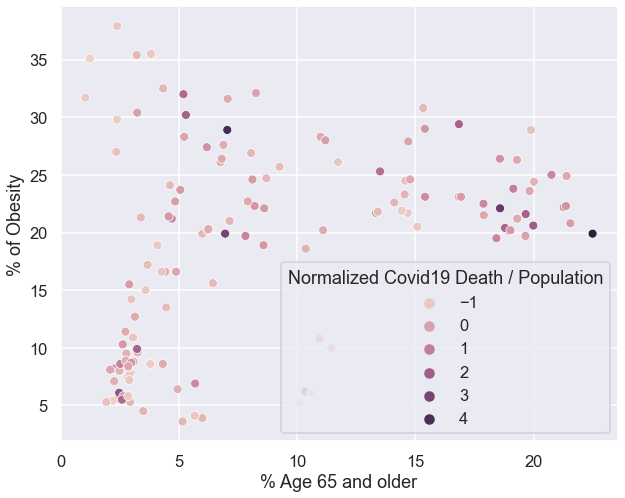

In [13]:
sns.scatterplot(data=df, x='Perc65Over', y='Obesity', hue='Normalized Covid19 Death / Population');
plt.xlabel("% Age 65 and older")
plt.ylabel("% of Obesity");

Text(0, 0.5, 'Latitude')

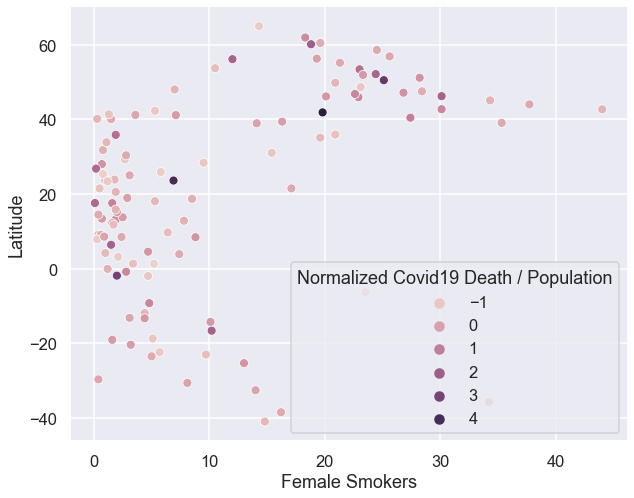

In [14]:
sns.scatterplot(data=df, x='female_smokers', y='Latitude', hue='Normalized Covid19 Death / Population');
plt.xlabel("Female Smokers")
plt.ylabel("Latitude")

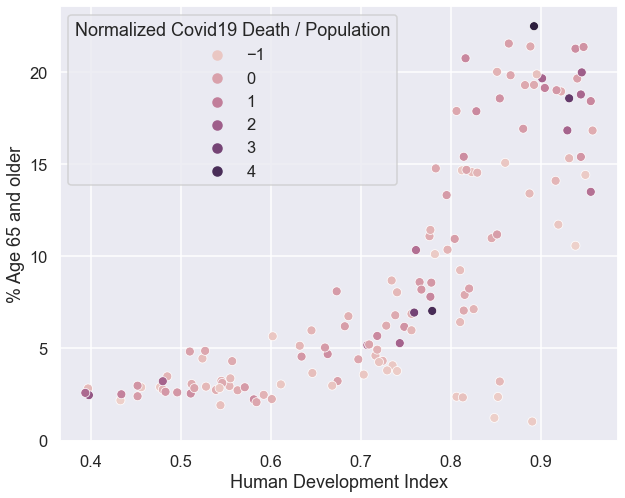

In [15]:
sns.scatterplot(data=df, x='human_development_index', y='Perc65Over', hue='Normalized Covid19 Death / Population');
plt.xlabel("Human Development Index")
plt.ylabel("% Age 65 and older");

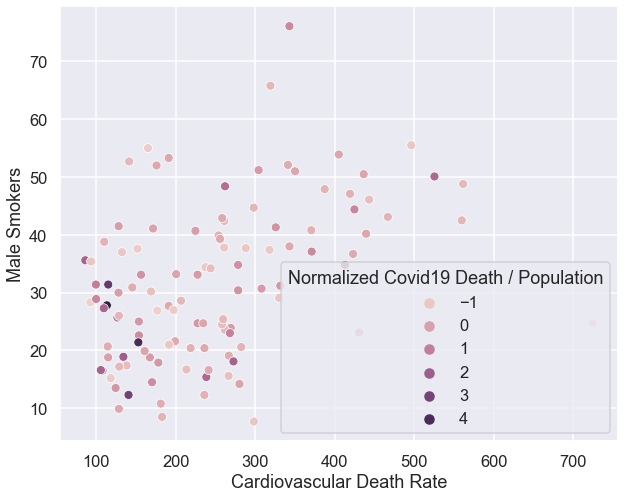

In [16]:
sns.scatterplot(data=df, x='cardiovasc_death_rate', y='male_smokers', hue='Normalized Covid19 Death / Population');
plt.xlabel("Cardiovascular Death Rate")
plt.ylabel("Male Smokers");

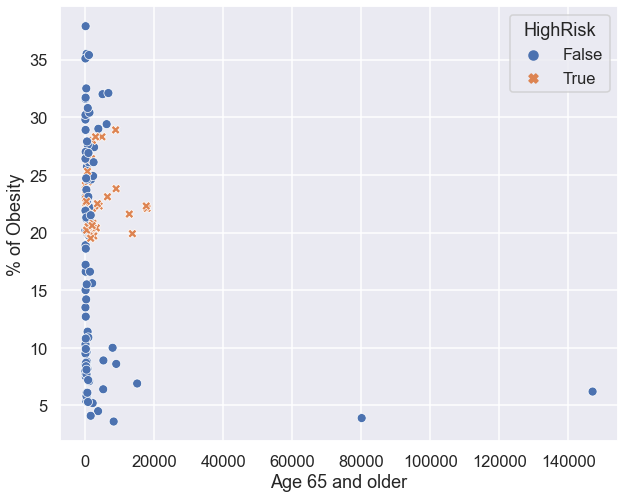

In [17]:
sns.scatterplot(data=df, x='Pop65Over', y='Obesity', hue='HighRisk', style='HighRisk');
plt.xlabel("Age 65 and older")
plt.ylabel("% of Obesity");

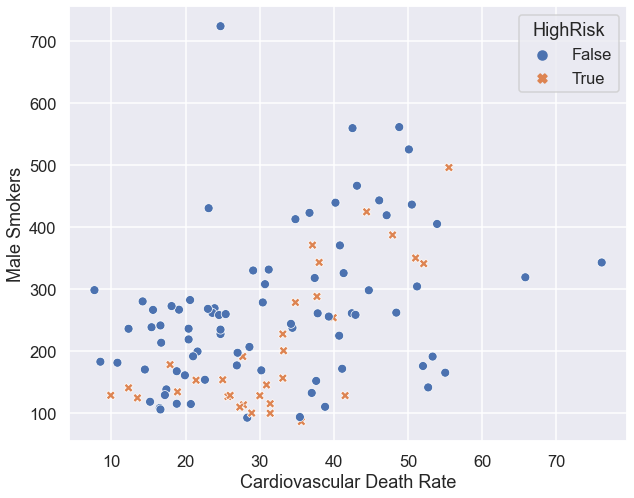

In [18]:
sns.scatterplot(data=df, x='male_smokers', y='cardiovasc_death_rate', hue='HighRisk', style='HighRisk');
plt.xlabel("Cardiovascular Death Rate")
plt.ylabel("Male Smokers");

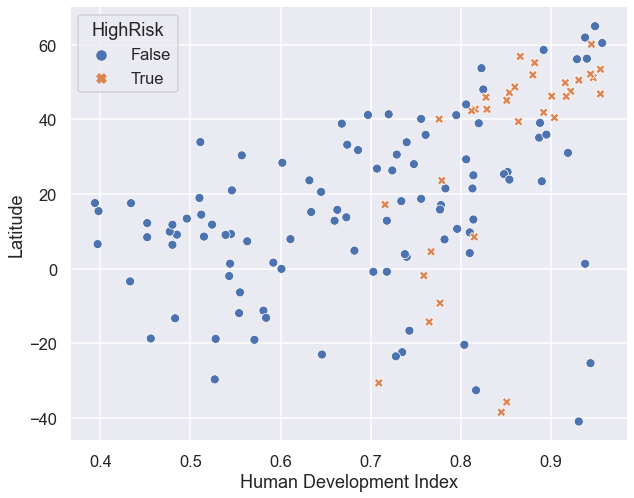

In [19]:
sns.scatterplot(data=df, x='human_development_index', y='Latitude', hue='HighRisk', style='HighRisk');
plt.xlabel("Human Development Index")
plt.ylabel("Latitude");

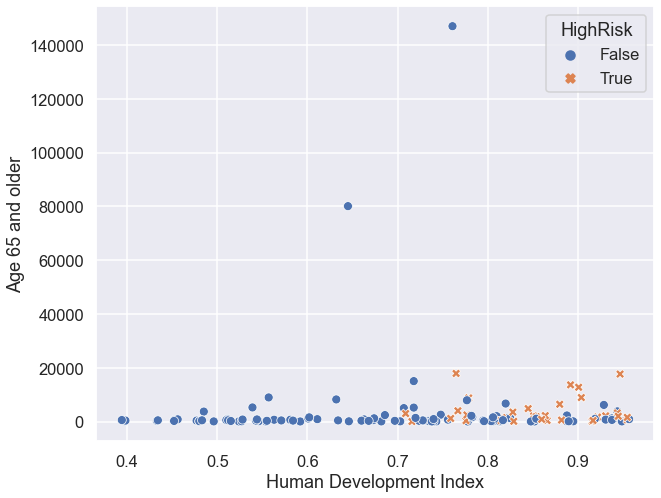

In [20]:
sns.scatterplot(data=df, x='human_development_index', y='Pop65Over', hue='HighRisk', style='HighRisk');
plt.xlabel("Human Development Index")
plt.ylabel("Age 65 and older");

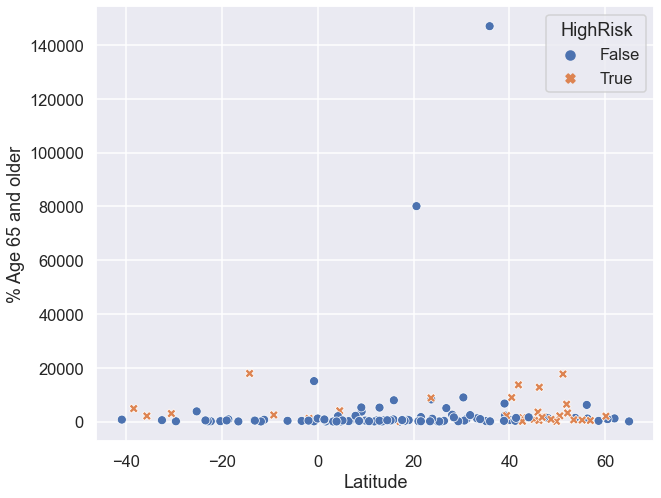

In [21]:
sns.scatterplot(data=df, x='Latitude', y='Pop65Over', hue='HighRisk', style='HighRisk');
plt.xlabel("Latitude")
plt.ylabel("% Age 65 and older");

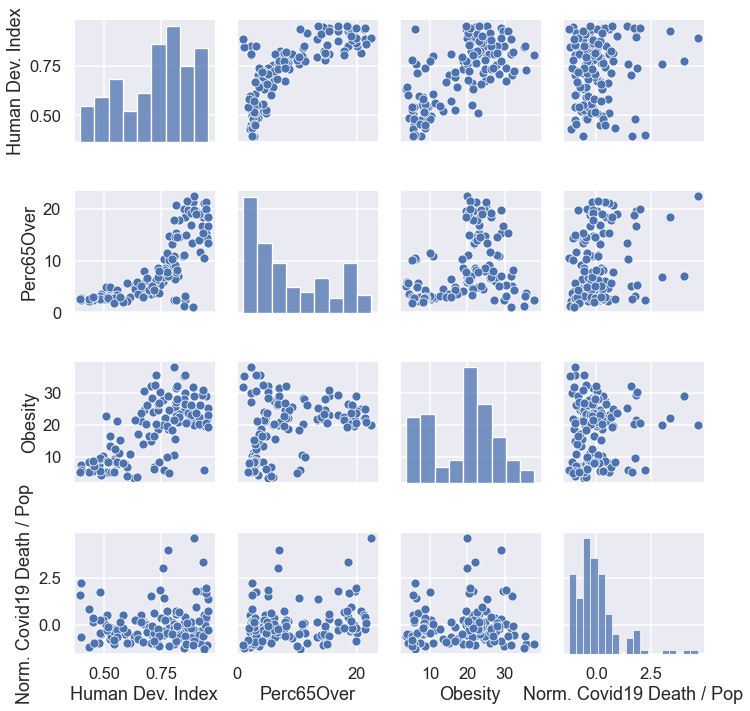

In [22]:
sns.pairplot(data=df[['Human Dev. Index', 'Perc65Over', 'Obesity', 'Norm. Covid19 Death / Pop']]);

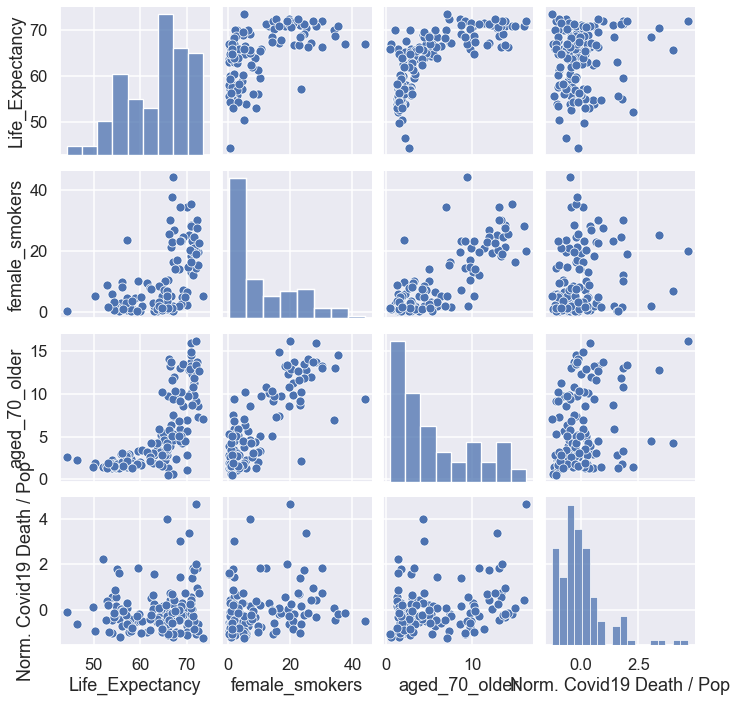

In [23]:
sns.pairplot(data=df[['Life_Expectancy','female_smokers', 'aged_70_older', 'Norm. Covid19 Death / Pop']]);

In [24]:
k = 7
predictors = ['Obesity', 'female_smokers', 'human_development_index', 'Life_Expectancy']
target = 'HighRisk'

# unscaled version (note that scaling is only used on predictor variables)
X = df[predictors].values
y = df[target].values

# Split the data into training and test sets, and scale
scaler = StandardScaler()

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
# scaled version
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

#Remove data rows with nan
y_train = y_train[~np.isnan(X_train).any(axis=1)]
X_train = X_train[~np.isnan(X_train).any(axis=1)]

y_test = y_test[~np.isnan(X_test).any(axis=1)]
X_test = X_test[~np.isnan(X_test).any(axis=1)]

knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)

acc = (predictions == y_test).mean()

print('Comparison of predictions to y_test values: \n\n', predictions == y_test)
print('\nPredictions:\n\n', predictions)
print('\nY_test values:\n\n', y_test)

print('\nAccurancy: ', acc)


Comparison of predictions to y_test values: 

 [ True  True  True  True  True  True  True  True  True  True  True  True
  True False  True False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True]

Predictions:

 [False  True False  True  True  True False False False False False False
 False  True  True False False  True False False False False False False
 False False False False  True  True  True False False False]

Y_test values:

 [False  True False  True  True  True False False False False False False
 False False  True  True False  True False False False False False False
 False False False False  True  True  True False False False]

Accurancy:  0.9411764705882353


### The model using the extra features especially the human_development_index, smoker data and more recent target data has gotten better at predicting a countries rate of mortality vs population going from 80% to 94% accuracy depending on the randomization with a mean of 89% using slightly diff features

#### This may be due to different reporting systems for what is and is not a covid death and overall accuracy of the inputs.  We are not sure what caused the Latitude to become an important feature, but some studies have shown that Vitamin D can help protect one from Covid and higher latitude countries tend to sumplement more.

#### Our original Hypotheses that Age and Obesity would be factors seem to have been proven true through the data, one might even be able to try regression on the normalized mortality / population and if we had the One World Data originally we may have even gone further and tried that as the correlation seems to be stronger.